In [21]:
!nvidia-smi

Thu Oct 16 15:47:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [22]:
!pip -q install --upgrade pip
!pip -q install opencv-python pillow matplotlib albumentations tqdm einops

# (Colab ships with torch/torchvision; uncomment if you need a specific CUDA build)
# !pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121

# Clone official MODNet
%cd /content
!git clone https://github.com/ZHKKKe/MODNet.git
%cd MODNet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.5 MB/s eta 0:00:00
/content
Cloning into 'MODNet'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 276 (delta 21), reused 16 (delta 16), pack-reused 236 (from 1)
Receiving objects: 100% (276/276), 60.77 MiB | 32.82 MiB/s, done.
Resolving deltas: 100% (100/100), done.
/content/MODNet


In [1]:
import os, sys, glob, math, random, time
from pathlib import Path
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image




device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
from pathlib import Path
import shutil
import random

# Define source dataset roots
AIM_ROOT = Path('/content/drive/MyDrive/AIM-500')
AIT_ROOT = Path('/content/drive/MyDrive/AIT_Faculty')

# Define destination root
DATA_ROOT = Path('/content/drive/MyDrive/modnet_data')

# Define split structure
splits = ['train', 'val', 'test']
subdirs = ['images', 'mattes']

# Create destination directories
for split in splits:
    for subdir in subdirs:
        (DATA_ROOT / split / subdir).mkdir(parents=True, exist_ok=True)

In [39]:
train_img_dir = DATA_ROOT / 'train' / 'images'
train_matte_dir = DATA_ROOT / 'train' / 'mattes'
val_img_dir = DATA_ROOT / 'val' / 'images'
val_matte_dir = DATA_ROOT / 'val' / 'mattes'
test_img_dir = DATA_ROOT / 'test' / 'images'
test_matte_dir = DATA_ROOT / 'test' / 'mattes'

In [40]:
print(train_img_dir)
print(train_matte_dir)
print(val_img_dir)
print(val_matte_dir)

/content/drive/MyDrive/modnet_data/train/images
/content/drive/MyDrive/modnet_data/train/mattes
/content/drive/MyDrive/modnet_data/val/images
/content/drive/MyDrive/modnet_data/val/mattes


In [41]:
# =====================================================
#  🧩 collect_pairs() — Match and auto-rename mattes
# =====================================================
from pathlib import Path
import os

def collect_pairs(original_dir: Path, mask_dir: Path, auto_rename=True):
    """
    Collect matching image–matte pairs even if:
      • File extensions differ (.jpg, .png, etc.)
      • Matte filenames include '_matte' suffix
    Optionally auto-renames mattes to match their images.
    Returns: list of (image_path, matte_path) tuples
    """
    original_files = list(original_dir.glob('*'))
    mask_files = list(mask_dir.glob('*'))

    # Build map of matte stems (handle '_matte' suffix)
    mask_map = {}
    for f in mask_files:
        stem = f.stem
        if stem.endswith('_matte'):
            stem = stem[:-6]  # remove suffix
        mask_map[stem] = f

    pairs = []
    renamed = 0
    for img_path in original_files:
        stem = img_path.stem

        # Direct match
        if stem in mask_map:
            matte_path = mask_map[stem]

            # Rename matte if name contains "_matte"
            if auto_rename and "_matte" in matte_path.stem:
                new_name = stem + matte_path.suffix
                new_path = matte_path.with_name(new_name)
                if not new_path.exists():
                    os.rename(matte_path, new_path)
                    matte_path = new_path
                    renamed += 1
                    print(f"✅ Renamed: {matte_path.name}")
                else:
                    print(f"⚠️ Skipped rename (exists): {new_name}")

            pairs.append((img_path, matte_path))

        else:
            # Try fuzzy match (partial overlap)
            match = next((m for k, m in mask_map.items() if stem in k or k in stem), None)
            if match:
                pairs.append((img_path, match))
            else:
                print(f"⚠️ No matching matte found for: {img_path.name}")

    print(f"\n✅ Collected {len(pairs)} valid pairs | 🔄 Renamed: {renamed}")
    return pairs


In [55]:
# Function to copy image-mask pairs to a split folder, skipping if already copied
def copy_split(pairs, split, dest_root):
    i=0;
    for img_path, mask_path in pairs:
        dest_img = dest_root / split / 'images' / img_path.name
        dest_mask = dest_root / split / 'mattes' / mask_path.name

        if not dest_img.exists() and not dest_mask.exists():
            i+=1
            print(str(i)+f" copying {img_path.name}")
            shutil.copy(img_path, dest_img)
            shutil.copy(mask_path, dest_mask)
        # if not dest_mask.exists():
        #     shutil.copy(mask_path, dest_mask)

In [51]:
# Function to split and copy a dataset directly
def split_and_copy(original_dir, mask_dir, split_ratios, dest_root):
    pairs = collect_pairs(original_dir, mask_dir)
    print(f"Found {len(pairs)} pairs in {original_dir}")

    random.shuffle(pairs)
    total = len(pairs)
    train_end = int(split_ratios[0] * total)
    val_end = train_end + int(split_ratios[1] * total)

    splits_map = {
        'train': pairs[:train_end],
        'val': pairs[train_end:val_end],
        'test': pairs[val_end:]
    }

    for split, items in splits_map.items():
        copy_split(items, split, dest_root)



In [52]:
# Apply to AIM and AIT datasets
split_ratios = [0.7, 0.15, 0.15]  # train, val, test


In [53]:
print("AIM images:", len(list(Path(AIM_ROOT/'original').glob('*'))))
print("AIM mattes:", len(list(Path(AIM_ROOT / 'mask').glob('*'))))
print("AIT images:", len(list(Path(AIT_ROOT / 'images').glob('*'))))
print("AIT mattes:", len(list(Path(AIT_ROOT / 'mattes').glob('*'))))


AIM images: 500
AIM mattes: 500
AIT images: 114
AIT mattes: 132


In [56]:
split_and_copy(AIM_ROOT / 'original', AIM_ROOT / 'mask', split_ratios, DATA_ROOT)


✅ Collected 500 valid pairs | 🔄 Renamed: 0
Found 500 pairs in /content/drive/MyDrive/AIM-500/original
1 copyingo_74234bc8.jpg
2 copyingo_dbef692f.jpg
3 copyingo_09b8ed47.jpg
4 copyingo_5a15b5f2.jpg
5 copyingo_77d7a529.jpg
6 copyingo_c0ca489f.jpg
7 copyingo_26b16002.jpg
8 copyingo_03d296a3.jpg
9 copyingo_ebc2e45c.jpg
10 copyingo_c060bd1c.jpg
11 copyingo_1c321c56.jpg
12 copyingo_71ed1e79.jpg
13 copyingo_669ed3b5.jpg
14 copyingo_093764ca.jpg
15 copyingo_660c8ca2.jpg
16 copyingo_2f033b3c.jpg
17 copyingo_cd5c068f.jpg
18 copyingo_5517109c.jpg
19 copyingo_e584f46f.jpg
20 copyingo_0530e2e7.jpg
21 copyingo_62f63948.jpg
22 copyingo_fae80c63.jpg
23 copyingo_418d6d35.jpg
24 copyingo_bb67ca50.jpg
25 copyingo_428276f8.jpg
26 copyingo_f07cde8a.jpg
27 copyingo_b085e7dc.jpg
28 copyingo_0a0ae43d.jpg
29 copyingo_bab88684.jpg
30 copyingo_3794e715.jpg
31 copyingo_7e3075f5.jpg
32 copyingo_9dbaf589.jpg
33 copyingo_f1ee35e0.jpg
34 copyingo_be63d1bf.jpg
35 copyingo_260f47c8.jpg
36 copyingo_e3fa38f7.jpg
37 cop

In [57]:
split_and_copy(AIT_ROOT / 'images', AIT_ROOT / 'mattes', split_ratios, DATA_ROOT)

✅ Renamed: Attaphongse Taparugssanage.png
✅ Renamed: Rajeshwari B.png
✅ Renamed: Mrs. Yashaswi H. V.png
✅ Renamed: Dr. Avirut Puttiwongrak.png
✅ Renamed: Prof.Avishek Datta.png
✅ Renamed: Dr. Arlene Lu-Gonzales.png
✅ Renamed: Andrew20Macintosh_edited.png
✅ Renamed: Prof.Ajit P.Annachhatre.png
✅ Renamed: Dr. Amararatne Yakupitiyage.png
✅ Renamed: Dr. Ayushman Bhatt.png
✅ Renamed: Mr. Benjamin Quinlan.png
✅ Renamed: Prof. Bonaventura H. W. Hadikusumo.png
✅ Renamed: Dr. Branesh Madhavan.png
✅ Renamed: Dr. Chaklam Silpasuwanchai.png
✅ Renamed: Dr.Chantri-Profile-Photo-For-Website-e1704251676272.png
✅ Renamed: Mr. Chaarnkurt Yaoyuenyong.png
✅ Renamed: Prof. Chettiyappan Visvanathan.png
✅ Renamed: Prof. Chongrak Polprasert.png
✅ Renamed: Dr. Chutiporn Anutariya.png
✅ Renamed: Prof. Deepak Sharma.png
✅ Renamed: Prof. Dieter Trau.png
✅ Renamed: Dr. Djoen San Santoso.png
✅ Renamed: Dr. Ekbordin Winijkul.png
✅ Renamed: Duke-Malan.png
✅ Renamed: Dr. Farhad Zulfiqar.png
✅ Renamed: Prof. Gajendra S

In [58]:
from pathlib import Path

print("Train images:", len(list(Path(train_img_dir).glob('*'))))
print("Train mattes:", len(list(Path(train_matte_dir).glob('*'))))
print("Val images:", len(list(Path(val_img_dir).glob('*'))))
print("Val mattes:", len(list(Path(val_matte_dir).glob('*'))))

Train images: 429
Train mattes: 429
Val images: 91
Val mattes: 91


In [59]:
import os, sys, importlib.util, types

# Path where you cloned the repo
repo_root = "/content/MODNet"
modnet_file = os.path.join(repo_root, "src", "models", "modnet.py")
backbones_file = os.path.join(repo_root, "src", "models", "backbones", "__init__.py")

# Create stub packages so relative imports in modnet.py work
pkg_src = types.ModuleType("src"); pkg_src.__path__ = [os.path.join(repo_root, "src")]
pkg_models = types.ModuleType("src.models"); pkg_models.__path__ = [os.path.join(repo_root, "src", "models")]
sys.modules["src"] = pkg_src
sys.modules["src.models"] = pkg_models

# Load backbones first
spec_bk = importlib.util.spec_from_file_location("src.models.backbones", backbones_file)
bk_mod = importlib.util.module_from_spec(spec_bk)
sys.modules["src.models.backbones"] = bk_mod
spec_bk.loader.exec_module(bk_mod)

# Load modnet
spec_md = importlib.util.spec_from_file_location("src.models.modnet", modnet_file)
modnet_mod = importlib.util.module_from_spec(spec_md)
sys.modules["src.models.modnet"] = modnet_mod
spec_md.loader.exec_module(modnet_mod)

# Get class
MODNet = modnet_mod.MODNet
print("✅ MODNet class loaded:", MODNet)

✅ MODNet class loaded: <class 'src.models.modnet.MODNet'>


In [60]:
# !mkdir -p /content/MODNet/pretrained
# !wget -q https://github.com/ZHKKKe/MODNet/releases/download/v1/modnet_webcam_portrait_matting.ckpt \
#     -O /content/MODNet/pretrained/modnet_webcam_portrait_matting.ckpt


In [61]:
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import os

def remove_unidentified(folder_path):
    folder = Path(folder_path)
    removed = []

    for file in folder.glob("*"):
        try:
            Image.open(file).verify()
        except UnidentifiedImageError:
            print(f"❌ Removing unreadable file: {file.name}")
            os.remove(file)
            removed.append(file.stem)  # store stem for cross-checking

    print(f"✅ Removed {len(removed)} files from {folder.name}")
    return removed

# Define your paths
# img_dir = "/content/drive/MyDrive/modnet_data/train/images"
# matte_dir = "/content/drive/MyDrive/modnet_data/train/mattes"

# Remove unreadable files
bad_img_stems = remove_unidentified(train_img_dir)
bad_matte_stems = remove_unidentified(train_matte_dir)

# Optional: remove mismatched pairs
def remove_mismatched_pairs(img_dir, matte_dir, bad_stems):
    for stem in bad_stems:
        img_file = list(Path(img_dir).glob(stem + ".*"))
        matte_file = list(Path(matte_dir).glob(stem + ".*"))
        for f in img_file + matte_file:
            if f.exists():
                print(f"🧹 Removing mismatched file: {f.name}")
                os.remove(f)

# Remove any remaining mismatched pairs
remove_mismatched_pairs(train_img_dir, train_matte_dir, set(bad_img_stems + bad_matte_stems))



✅ Removed 0 files from images
✅ Removed 0 files from mattes


In [62]:
# =====================================================
#  🧩 Updated PortraitDataset (Fix Normalize Issue)
# =====================================================
class PortraitDataset(Dataset):
    def __init__(self, img_dir, matte_dir, img_transform=None, matte_transform=None):
        self.img_dir = Path(img_dir)
        self.matte_dir = Path(matte_dir)
        self.img_transform = img_transform
        self.matte_transform = matte_transform

        img_stems = {p.stem for p in self.img_dir.glob('*')}
        matte_stems = {p.stem for p in self.matte_dir.glob('*')}
        self.common_stems = sorted(list(img_stems & matte_stems))
        print(f"✅ Found {len(self.common_stems)} paired samples in {self.img_dir.parent.name}")

    def __len__(self):
        return len(self.common_stems)

    def __getitem__(self, idx):
          stem = self.common_stems[idx]

          img_matches = list(self.img_dir.glob(stem + '.*'))
          matte_matches = list(self.matte_dir.glob(stem + '.*'))

          if not img_matches or not matte_matches:
              print(f"⚠️ Missing file for stem: {stem}")
              return self.__getitem__((idx + 1) % len(self.common_stems))  # fallback to next sample

          img_path = img_matches[0]
          matte_path = matte_matches[0]

          try:
              image = Image.open(img_path).convert("RGB")
              matte = Image.open(matte_path).convert("L")
          except UnidentifiedImageError:
              print(f"❌ Unreadable image or matte: {stem}")
              return self.__getitem__((idx + 1) % len(self.common_stems))

          if self.img_transform:
              image = self.img_transform(image)
          if self.matte_transform:
              matte = self.matte_transform(matte)

          return image, matte

In [63]:
import torchvision.transforms as T

transform_img = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])

transform_matte = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])

In [64]:
train_img_dir = Path('/content/drive/MyDrive/modnet_data/train/images')
train_matte_dir = Path('/content/drive/MyDrive/modnet_data/train/mattes')



print("Images folder exists:", train_img_dir.exists())
print("Mattes folder exists:", train_matte_dir.exists())
print("Number of image files:", len(list(train_img_dir.glob('*'))))
print("Number of matte files:", len(list(train_matte_dir.glob('*'))))

Images folder exists: True
Mattes folder exists: True
Number of image files: 429
Number of matte files: 429


In [66]:
print("First 10 stems found in images:", sorted([p.stem for p in train_img_dir.glob('*')])[:10])
print("First 10 stems found in mattes:", sorted([p.stem for p in train_matte_dir.glob('*')])[:10])


First 10 stems found in images: ['Andrew20Macintosh_edited', 'Attaphongse Taparugssanage', 'Dr. Avirut Puttiwongrak', 'Dr. Branesh Madhavan', 'Dr. Chaklam Silpasuwanchai', 'Dr. Chutiporn Anutariya', 'Dr. Djoen San Santoso', 'Dr. Farhad Zulfiqar', 'Dr. Gerard Tocquer', 'Dr. Hayat Ullah']
First 10 stems found in mattes: ['Andrew20Macintosh_edited', 'Attaphongse Taparugssanage', 'Dr. Avirut Puttiwongrak', 'Dr. Branesh Madhavan', 'Dr. Chaklam Silpasuwanchai', 'Dr. Chutiporn Anutariya', 'Dr. Djoen San Santoso', 'Dr. Farhad Zulfiqar', 'Dr. Gerard Tocquer', 'Dr. Hayat Ullah']


In [79]:

from torch.utils.data import DataLoader
from torchvision import transforms

# --- Image preprocessing ---
# Resize all samples to 512×512 (MODNet input size) and convert to tensors
# Normalization is optional here; MODNet uses range [-1, 1] internally.
transform_train = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

transform_val = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# --- Create Dataset instances ---
train_ds = PortraitDataset(
    train_img_dir,
    train_matte_dir,
    img_transform=transform_train,
    # matte_transform=transform_matte_train  # optional
    matte_transform=transform_matte
)

val_ds = PortraitDataset(
    val_img_dir,
    val_matte_dir,
    img_transform=transform_val,
    # matte_transform=transform_matte_val  # optional
    matte_transform=transform_matte
)

# --- DataLoaders ---
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)


print(f"✅ Train set: {len(train_ds)} samples, Val set: {len(val_ds)} samples")


✅ Found 429 paired samples in train
✅ Found 91 paired samples in val
✅ Train set: 429 samples, Val set: 91 samples


In [70]:
# =====================================================
#  🧩 Part 3 — Load Pretrained MODNet Model
# =====================================================
import torch
from pathlib import Path
import sys

# # --- Device setup ---
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"🧠 Using device: {device}")

# # --- Add MODNet source path ---
# # Make sure you cloned MODNet official repo or have the source in your environment.
# MODNET_PATH = Path('/content/MODNet/src')  # adjust if needed
# if not MODNET_PATH.exists():
#     raise FileNotFoundError("❌ MODNet source path not found! Please clone it into /content/MODNet")

# if str(MODNET_PATH) not in sys.path:
#     sys.path.append(str(MODNET_PATH))

# --- Import the model class ---
# from models.modnet import MODNet

# --- Initialize model ---
model = MODNet(backbone_pretrained=False).to(device)

# --- Load pretrained checkpoint ---
pretrained_model_name ='modnet_photographic_portrait_matting.ckpt'
PRETRAINED_CKPT = Path('/content/drive/MyDrive/modnet_data/pretrained/'+pretrained_model_name)
print(f"📂 Loading pretrained weights from: {PRETRAINED_CKPT}")

state = torch.load(PRETRAINED_CKPT, map_location=device)

# handle different checkpoint formats
if isinstance(state, dict) and 'state_dict' in state:
    state = state['state_dict']
state = {k.replace('module.', ''): v for k, v in state.items()}

missing, unexpected = model.load_state_dict(state, strict=False)
print(f"✅ Model loaded. Missing: {len(missing)} | Unexpected: {len(unexpected)}")

# --- Set to training mode ---
model.train()


📂 Loading pretrained weights from: /content/drive/MyDrive/modnet_data/pretrained/modnet_photographic_portrait_matting.ckpt
✅ Model loaded. Missing: 0 | Unexpected: 0


MODNet(
  (backbone): MobileNetV2Backbone(
    (model): MobileNetV2(
      (features): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
            (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [71]:
# =====================================================
#  🧩 Part 4 — Define Loss Function and Optimizer
# =====================================================
import torch.nn.functional as F

# --- Loss Function ---
# MODNet predicts the alpha matte, so we use L1 (absolute error) loss
# You can combine with L2 or add edge loss later for refinement.
def matte_loss(pred, target):
    """Compute L1 loss between predicted and ground-truth matte."""
    return F.l1_loss(pred, target)

# --- Optimizer ---
# AdamW is preferred for stability; fine-tuning usually needs a small LR
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-5,         # lower learning rate for fine-tuning
    weight_decay=1e-4
)

# --- Optional: Learning Rate Scheduler ---
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print("✅ Optimizer and loss function are ready.")


✅ Optimizer and loss function are ready.


In [72]:
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Train loader size: {len(train_loader)}")
print(f"Validation loader size: {len(val_loader)}")

Train dataset size: 429
Validation dataset size: 91
Train loader size: 108
Validation loader size: 46


In [73]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    loop = tqdm(dataloader, desc="Training")

    for imgs, mattes in loop:
        imgs, mattes = imgs.to(device), mattes.to(device)

        optimizer.zero_grad()
        _, _, pred_mattes = model(imgs, True)
        loss = loss_fn(pred_mattes, mattes)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return running_loss / len(dataloader)

In [74]:
def validate_one_epoch(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for imgs, mattes in tqdm(dataloader, desc="Validation"):
            imgs, mattes = imgs.to(device), mattes.to(device)
            _, _, pred_mattes = model(imgs, True)
            loss = loss_fn(pred_mattes, mattes)
            val_loss += loss.item()

    return val_loss / len(dataloader)

In [75]:
def test_model(model, dataloader, device, save_dir=None):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        for idx, (imgs, _) in enumerate(tqdm(dataloader, desc="Testing")):
            imgs = imgs.to(device)
            _, _, pred_mattes = model(imgs, True)

            for i in range(imgs.size(0)):
                matte_np = pred_mattes[i].squeeze().cpu().numpy() * 255
                matte_img = Image.fromarray(matte_np.astype(np.uint8))
                matte_img.save(f"{save_dir}/matte_{idx}_{i}.png")

In [90]:
import numpy as np
from skimage.metrics import structural_similarity

def compute_metrics(pred, gt):
    pred_np = pred.squeeze().cpu().numpy()
    gt_np = gt.squeeze().cpu().numpy()

    # Normalize to [0, 1]
    pred_np = np.clip(pred_np, 0, 1)
    gt_np = np.clip(gt_np, 0, 1)

    # SSIM
    ssim_val = structural_similarity(pred_np, gt_np, data_range=1.0)

    # MAE
    mae_val = np.mean(np.abs(pred_np - gt_np))

    # IoU
    pred_bin = pred_np > 0.5
    gt_bin = gt_np > 0.5
    intersection = np.logical_and(pred_bin, gt_bin).sum()
    union = np.logical_or(pred_bin, gt_bin).sum()
    iou_val = intersection / union if union > 0 else 0.0

    return ssim_val, mae_val, iou_val

In [91]:
import torch

def evaluate_metrics(model, val_loader, device):
    ssim_total, mae_total, iou_total, count = 0.0, 0.0, 0.0, 0
    model.eval()
    with torch.no_grad():
        val_iter = iter(val_loader)
        try:
            imgs, mattes = next(val_iter)
            imgs, mattes = imgs.to(device), mattes.to(device)
            _, _, pred_mattes = model(imgs, True)
            for i in range(imgs.size(0)):
                ssim_val, mae_val, iou_val = compute_metrics(pred_mattes[i], mattes[i])
                ssim_total += ssim_val
                mae_total += mae_val
                iou_total += iou_val
                count += 1
        except StopIteration:
            print("⚠️ Validation loader is empty. Skipping metrics.")
        finally:
            del val_iter

    if count > 0:
        return (
            ssim_total / count,
            mae_total / count,
            iou_total / count
        )
    else:
        return None, None, None

In [92]:
EPOCHS = 30
train_losses = []
val_losses = []
ssim_scores = []
mae_scores = []
iou_scores = []

for epoch in range(EPOCHS):
    print(f"\n🔁 Epoch {epoch+1}/{EPOCHS}")

    # Training
    train_loss = train_one_epoch(model, train_loader, optimizer, matte_loss, device)
    train_losses.append(train_loss)

    # Validation
    val_loss = validate_one_epoch(model, val_loader, matte_loss, device)
    val_losses.append(val_loss)

    # Metrics
    ssim_val, mae_val, iou_val = evaluate_metrics(model, val_loader, device)
    ssim_scores.append(ssim_val)
    mae_scores.append(mae_val)
    iou_scores.append(iou_val)

    print(f"📉 Train Loss: {train_loss:.6f} | ✅ Val Loss: {val_loss:.6f}")
    if ssim_val is not None:
        print(f"📈 SSIM: {ssim_val:.4f} | MAE: {mae_val:.4f} | IoU: {iou_val:.4f}")
    else:
        print("📈 SSIM, MAE, IoU: Skipped due to empty validation batch.")

    scheduler.step()


🔁 Epoch 1/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.016520 | ✅ Val Loss: 0.020528
📈 SSIM: 0.9855 | MAE: 0.0041 | IoU: 0.9973

🔁 Epoch 2/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.017457 | ✅ Val Loss: 0.022036
📈 SSIM: 0.9837 | MAE: 0.0043 | IoU: 0.9970

🔁 Epoch 3/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c5dfe1358a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c5dfe1358a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.016165 | ✅ Val Loss: 0.020851
📈 SSIM: 0.9854 | MAE: 0.0041 | IoU: 0.9972

🔁 Epoch 4/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.017021 | ✅ Val Loss: 0.020954
📈 SSIM: 0.9854 | MAE: 0.0042 | IoU: 0.9972

🔁 Epoch 5/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.016599 | ✅ Val Loss: 0.021427
📈 SSIM: 0.9865 | MAE: 0.0039 | IoU: 0.9972

🔁 Epoch 6/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.016148 | ✅ Val Loss: 0.021268
📈 SSIM: 0.9852 | MAE: 0.0042 | IoU: 0.9971

🔁 Epoch 7/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.016012 | ✅ Val Loss: 0.020783
📈 SSIM: 0.9854 | MAE: 0.0042 | IoU: 0.9973

🔁 Epoch 8/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.016189 | ✅ Val Loss: 0.022637
📈 SSIM: 0.9840 | MAE: 0.0042 | IoU: 0.9971

🔁 Epoch 9/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.018858 | ✅ Val Loss: 0.020297
📈 SSIM: 0.9849 | MAE: 0.0043 | IoU: 0.9970

🔁 Epoch 10/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.015905 | ✅ Val Loss: 0.021655
📈 SSIM: 0.9847 | MAE: 0.0042 | IoU: 0.9972

🔁 Epoch 11/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.017001 | ✅ Val Loss: 0.020925
📈 SSIM: 0.9863 | MAE: 0.0040 | IoU: 0.9973

🔁 Epoch 12/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c5dfe1358a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c5dfe1358a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.016204 | ✅ Val Loss: 0.022491
📈 SSIM: 0.9867 | MAE: 0.0040 | IoU: 0.9973

🔁 Epoch 13/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.015766 | ✅ Val Loss: 0.021137
📈 SSIM: 0.9858 | MAE: 0.0040 | IoU: 0.9974

🔁 Epoch 14/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.015740 | ✅ Val Loss: 0.021789
📈 SSIM: 0.9864 | MAE: 0.0040 | IoU: 0.9971

🔁 Epoch 15/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.014932 | ✅ Val Loss: 0.021045
📈 SSIM: 0.9857 | MAE: 0.0039 | IoU: 0.9974

🔁 Epoch 16/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.015973 | ✅ Val Loss: 0.023023
📈 SSIM: 0.9869 | MAE: 0.0040 | IoU: 0.9972

🔁 Epoch 17/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.015631 | ✅ Val Loss: 0.022792
📈 SSIM: 0.9863 | MAE: 0.0039 | IoU: 0.9972

🔁 Epoch 18/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.016292 | ✅ Val Loss: 0.022069
📈 SSIM: 0.9860 | MAE: 0.0039 | IoU: 0.9970

🔁 Epoch 19/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.016151 | ✅ Val Loss: 0.021422
📈 SSIM: 0.9850 | MAE: 0.0040 | IoU: 0.9973

🔁 Epoch 20/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.016279 | ✅ Val Loss: 0.021753
📈 SSIM: 0.9850 | MAE: 0.0041 | IoU: 0.9972

🔁 Epoch 21/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.015088 | ✅ Val Loss: 0.022201
📈 SSIM: 0.9860 | MAE: 0.0040 | IoU: 0.9973

🔁 Epoch 22/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.016567 | ✅ Val Loss: 0.022741
📈 SSIM: 0.9865 | MAE: 0.0039 | IoU: 0.9974

🔁 Epoch 23/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.015748 | ✅ Val Loss: 0.021997
📈 SSIM: 0.9860 | MAE: 0.0039 | IoU: 0.9971

🔁 Epoch 24/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.015340 | ✅ Val Loss: 0.020766
📈 SSIM: 0.9862 | MAE: 0.0039 | IoU: 0.9972

🔁 Epoch 25/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.015957 | ✅ Val Loss: 0.021396
📈 SSIM: 0.9879 | MAE: 0.0038 | IoU: 0.9973

🔁 Epoch 26/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c5dfe1358a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c5dfe1358a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.016543 | ✅ Val Loss: 0.023501
📈 SSIM: 0.9855 | MAE: 0.0040 | IoU: 0.9972

🔁 Epoch 27/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.015815 | ✅ Val Loss: 0.022160
📈 SSIM: 0.9876 | MAE: 0.0038 | IoU: 0.9973

🔁 Epoch 28/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.015696 | ✅ Val Loss: 0.021147
📈 SSIM: 0.9856 | MAE: 0.0041 | IoU: 0.9972

🔁 Epoch 29/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.015033 | ✅ Val Loss: 0.021802
📈 SSIM: 0.9855 | MAE: 0.0040 | IoU: 0.9972

🔁 Epoch 30/30


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

📉 Train Loss: 0.016785 | ✅ Val Loss: 0.021115
📈 SSIM: 0.9872 | MAE: 0.0039 | IoU: 0.9975


In [99]:
print("Lengths:")
print("Train Losses:", len(train_losses))
print("Val Losses:", len(val_losses))
print("SSIM:", len(ssim_scores))
print("MAE:", len(mae_scores))
print("IoU:", len(iou_scores))

Lengths:
Train Losses: 30
Val Losses: 30
SSIM: 30
MAE: 30
IoU: 30


In [100]:
import math

filtered = [
    (t, v, s, m, i)
    for t, v, s, m, i in zip(train_losses, val_losses, ssim_scores, mae_scores, iou_scores)
    if s is not None and not math.isnan(s)
]

train_losses, val_losses, ssim_scores, mae_scores, iou_scores = zip(*filtered)

In [103]:
import matplotlib.pyplot as plt

def plot_metric(metric_values, title, ylabel, color="blue"):
    epochs = range(1, len(metric_values) + 1)
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, metric_values, label=title, color=color)
    plt.title(f"{title} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

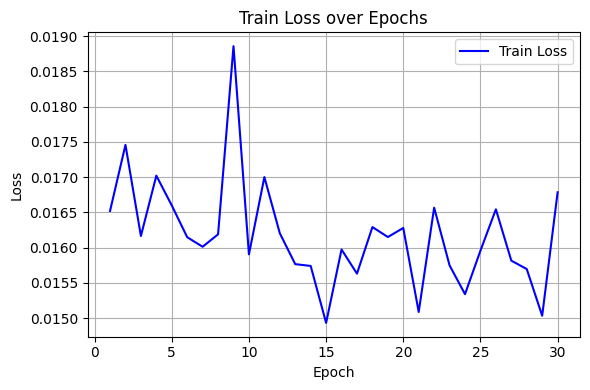

In [105]:
plot_metric(train_losses, "Train Loss", "Loss", "blue")


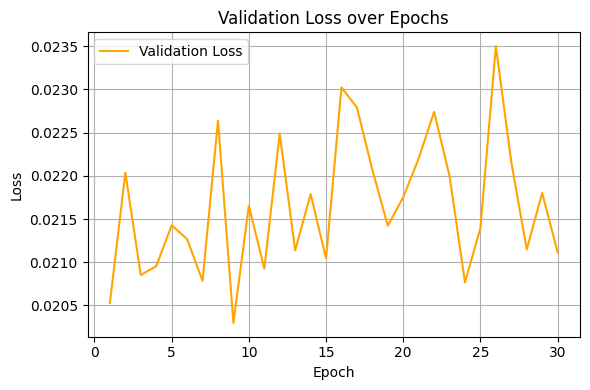

In [106]:
plot_metric(val_losses, "Validation Loss", "Loss", "orange")


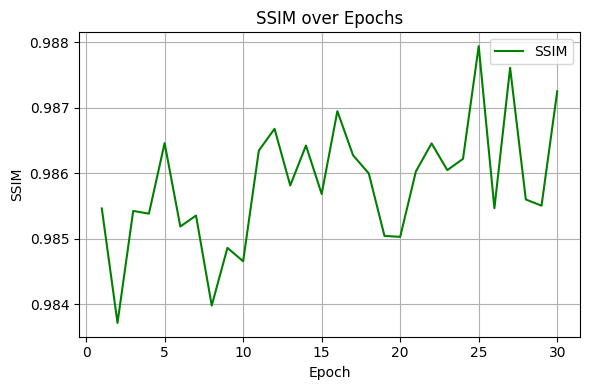

In [107]:
plot_metric(ssim_scores, "SSIM", "SSIM", "green")


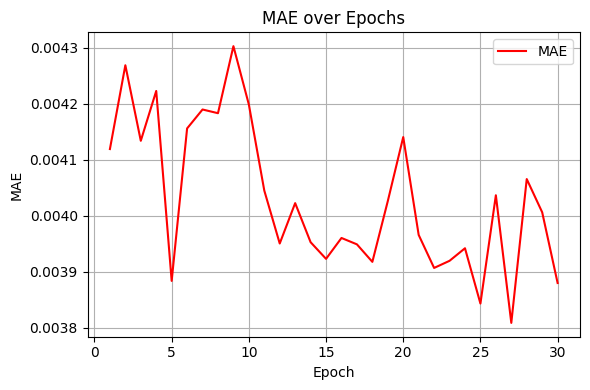

In [108]:
plot_metric(mae_scores, "MAE", "MAE", "red")


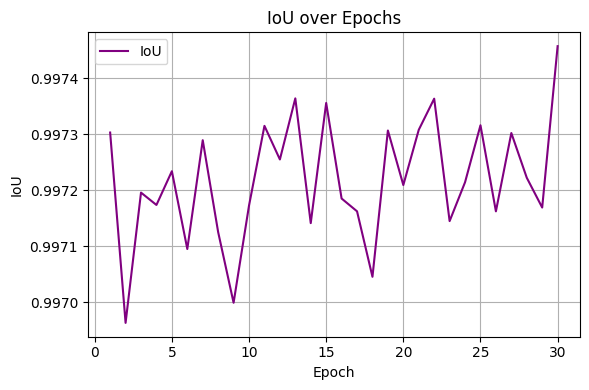

In [109]:
plot_metric(iou_scores, "IoU", "IoU", "purple")

In [110]:
SAVE_DIR = Path('/content/drive/MyDrive/modnet_data/output_models')
SAVE_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = SAVE_DIR / 'modnet_finetuned_photographic.ckpt'
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved to: {MODEL_PATH}")



✅ Model saved to: /content/drive/MyDrive/modnet_data/output_models/modnet_finetuned_photographic.ckpt


In [111]:
import matplotlib.pyplot as plt
import torch

def plot_val_samples(model, val_loader, device, num_samples=3):
    model.eval()
    with torch.no_grad():
        val_iter = iter(val_loader)
        try:
            imgs, mattes = next(val_iter)
            imgs, mattes = imgs.to(device), mattes.to(device)
            _, _, pred_mattes = model(imgs, True)

            for i in range(min(num_samples, imgs.size(0))):
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(imgs[i].permute(1, 2, 0).cpu().numpy())
                axs[0].set_title("Input Image")
                axs[0].axis("off")

                axs[1].imshow(mattes[i].squeeze().cpu().numpy(), cmap="gray")
                axs[1].set_title("Ground Truth Matte")
                axs[1].axis("off")

                axs[2].imshow(pred_mattes[i].squeeze().cpu().numpy(), cmap="gray")
                axs[2].set_title("Predicted Matte")
                axs[2].axis("off")

                plt.tight_layout()
                plt.show()

        except StopIteration:
            print("⚠️ Validation loader is empty. No samples to plot.")
        finally:
            del val_iter

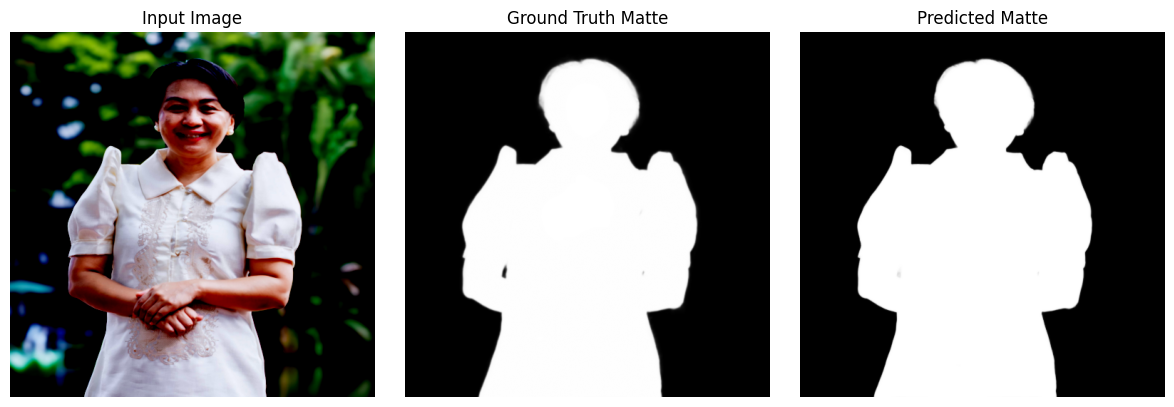

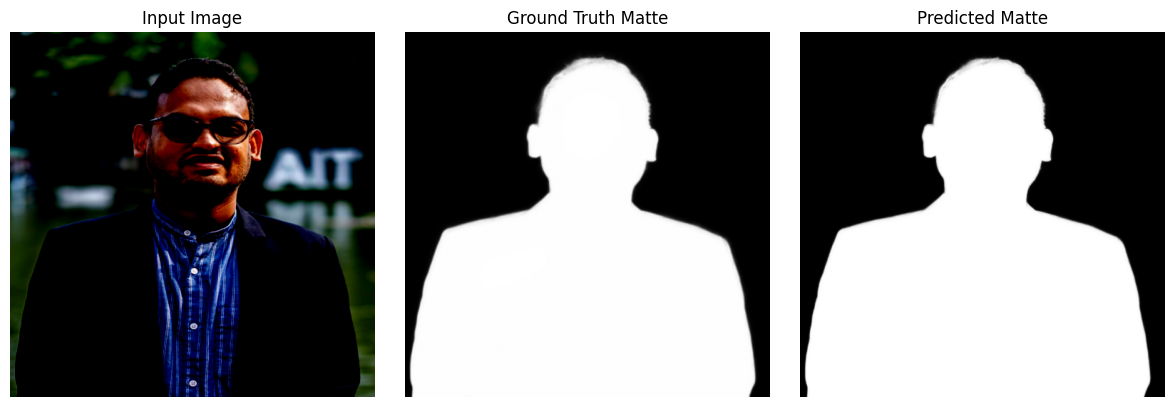

In [112]:
plot_val_samples(model, val_loader, device, num_samples=3)